# Exploratory Data Analysis: example (Heart Disease UCI database)
In this notebook i'll cover few methodologies and tools used in EDA process:

    1. Download data  
    2. Review data (attributes types and values, distributions etc.)
    3. Handle outliers
    4. Feature engineering (one-hot encoding for non-numerical attributes and feature extraction for numerical)
    5. Normalize features (Min-Max)
    6. Split data to Train-Test
    7. PCA and Logistic Regression

In [1]:
%%capture
!pip install kaggle

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from kaggle.api.kaggle_api_extended import KaggleApi
from shutil import copyfile
from zipfile import ZipFile
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

## 1. Download database
source: https://www.kaggle.com/ronitf/heart-disease-uci

In [3]:
%%capture
file_name = 'kaggle.json'
src = file_name
dst = os.path.join(os.path.expanduser("~"), '.kaggle', file_name)
copyfile(src, dst)
api = KaggleApi()
api.authenticate()

In [4]:
api.dataset_download_files('ronitf/heart-disease-uci')
zf = ZipFile('heart-disease-uci.zip')
zf.extractall() 
zf.close()

## 2. Review data
### Attribute Information:

    target: heart disease (0 = no; 1 = yes)

    1. age:      age
    2. sex:      sex (0 = female; 1 = male)
    3. cp:       chest pain type:
                 -- 0 = typical angina
                 -- 1 = atypical angina
                 -- 2 = non-anginal pain 
                 -- 3 = asymptomatic
    4. trestbps: resting blood pressure
    5. chol:     serum cholestoral in mg/dl
    6. fbs:      fasting blood sugar > 120 mg/dl (0 = false; 1 = true)
    7. restecg:  resting electrocardiographic results:
                 -- 0 = normal
                 -- 1 = having ST-T wave abnormality
                 -- 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria
    8. thalach:  maximum heart rate achieved
    9. exang:    exercise induced angina (0 = no; 1 = yes)
    10. oldpeak: ST depression induced by exercise relative to rest
    11. slope:   the slope of the peak exercise ST segment:
                 -- 0 = upsloping
                 -- 1 = flat
                 -- 2 = downsloping
    12. ca:      number of major vessels (0-3) colored by flouroscopy
    13. thal:    3 = normal; 6 = fixed defect; 7 = reversable defect

In [5]:
df=pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


* 13 features and 1 target in 303 samples

In [6]:
df.shape

(303, 14)

* all numerical values (even though most of them has no numericallogic - sex for instance is male/female)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [8]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


### Review target attribute

* target: heart disease (0 = no, 1 = yes)
* **~54.5%** have heart disease, **~45.5%** don't

In [9]:
df.target.unique()

array([1, 0])

In [10]:
df.target.value_counts(normalize = True)

1    0.544554
0    0.455446
Name: target, dtype: float64

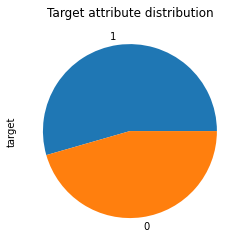

In [11]:
df.target.value_counts().plot(kind='pie', title='Target attribute distribution');

### Review non-numerical attributes

* sex (0 = female; 1 = male)
* **~68%** male, **~32%** female

In [12]:
df.sex.unique()

array([1, 0])

In [13]:
df.sex.value_counts(normalize = True)

1    0.683168
0    0.316832
Name: sex, dtype: float64

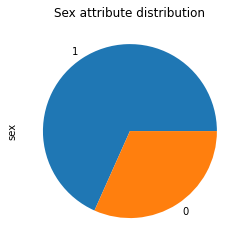

In [14]:
df.sex.value_counts().plot(kind='pie', title='Sex attribute distribution');

* chest pain type (0 = typical angina; 1 = atypical angina; 2 = non-anginal pain; 3 = asymptomatic)
* **~47%** typical angina, **~29%** non-anginal pain, **16.5%** atypical angina, **7.5%** asymptomatic

In [15]:
df.cp.unique()

array([3, 2, 1, 0])

In [16]:
df.cp.value_counts(normalize = True)

0    0.471947
2    0.287129
1    0.165017
3    0.075908
Name: cp, dtype: float64

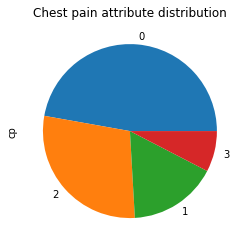

In [17]:
df.cp.value_counts().plot(kind='pie', title='Chest pain attribute distribution');

* fasting blood sugar > 120 mg/dl (0 = false; 1 = true)
* **~85%** low fbs, **~15%** high fbs

In [18]:
df.fbs.unique()

array([1, 0])

In [19]:
df.fbs.value_counts(normalize = True)

0    0.851485
1    0.148515
Name: fbs, dtype: float64

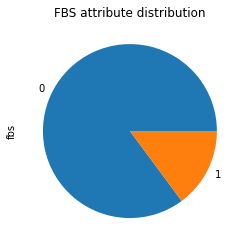

In [20]:
df.fbs.value_counts().plot(kind='pie', title='FBS attribute distribution');

* resting electrocardiographic results (0 = normal; 1 = having ST-T wave abnormality; 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
* **~50%** ST-T wave abnormality, **~48.5%** normal, **~1.3%** showing probable or definite left ventricular hypertrophy by Estes' criteria

In [21]:
df.restecg.unique()

array([0, 1, 2])

In [22]:
df.restecg.value_counts(normalize = True)

1    0.501650
0    0.485149
2    0.013201
Name: restecg, dtype: float64

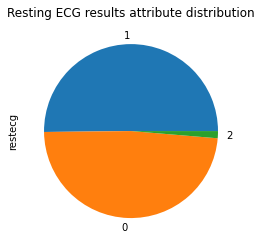

In [23]:
df.restecg.value_counts().plot(kind='pie', title='Resting ECG results attribute distribution');

* exercise induced angina (0 = no; 1 = yes)
* **~67%** with no exercise induced angina, **~33%** with exercise induced angina

In [24]:
df.exang.unique()

array([0, 1])

In [25]:
df.exang.value_counts(normalize = True)

0    0.673267
1    0.326733
Name: exang, dtype: float64

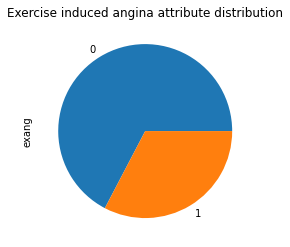

In [26]:
df.exang.value_counts().plot(kind='pie', title='Exercise induced angina attribute distribution');

* the slope of the peak exercise ST segment (0 = upsloping; 1 = flat; 2 = downsloping)
* **~47%** of the peak exercise ST segments were downslops, **~46%** of the peak exercise ST segments were flat and **~7%** of the peak exercise ST segments were upslopes

In [27]:
df.slope.unique()

array([0, 2, 1])

In [28]:
df.slope.value_counts(normalize = True)

2    0.468647
1    0.462046
0    0.069307
Name: slope, dtype: float64

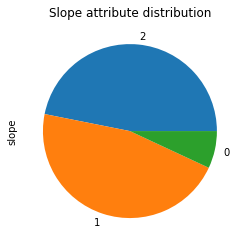

In [29]:
df.slope.value_counts().plot(kind='pie', title='Slope attribute distribution');

In [30]:
df.thal.unique()  # doesn't comply to dataset description

array([1, 2, 3, 0])

### Review numerical attributes

In [31]:
cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
df[cols].describe()

,age,trestbps,chol,thalach,oldpeak,ca
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,1.039604,0.729373
std,9.082101,17.538143,51.830751,22.905161,1.161075,1.022606
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000
25%,47.500000,120.000000,211.000000,133.500000,0.000000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000,0.000000
75%,61.000000,140.000000,274.500000,166.000000,1.600000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,4.000000


* add mesurment units to column names:
    1. age : [years]
    2. trestbps (resting blood pressure) : [systolic]
    3. chol_mgdl (serum cholestoral) : [milligrams per deciliter]
    4. thalach_bpm (maximum heart rate achieved) : [beats per minute]
    5. oldpeak (ST depression) : [millimeters]
    6. ca (number of major vessels colored by flouroscopy) : [number]

In [32]:
df.rename({'age': 'age_years', 'trestbps': 'trestbps_systolic', 'chol': 'chol_mgdl', 'thalach': 'thalach_bpm', 'oldpeak': 'oldpeak_mm', 'ca': 'ca_number'}, axis='columns', inplace=True)
df.head()

,age_years,sex,cp,trestbps_systolic,chol_mgdl,fbs,restecg,thalach_bpm,exang,oldpeak_mm,slope,ca_number,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


* histograme of subjects ages (in years)

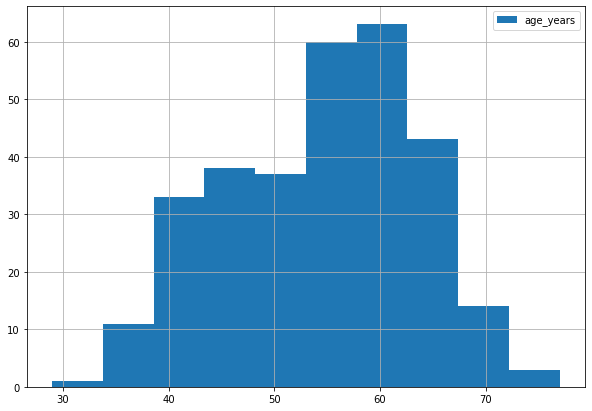

In [33]:
df['age_years'].hist(figsize=(10,7), legend=True);

* histograms of the subjects tests results

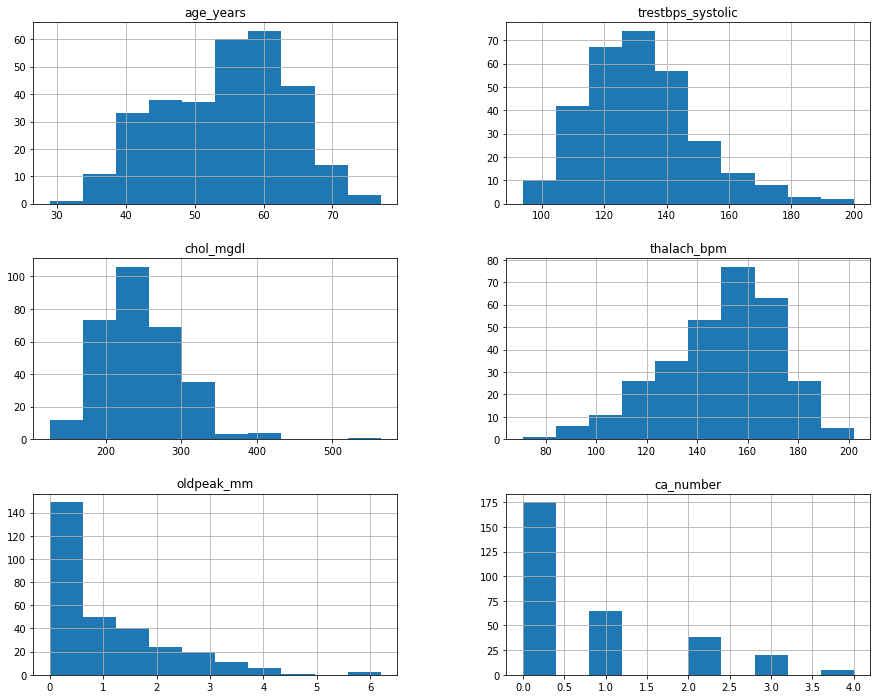

In [34]:
cols = ['age_years', 'trestbps_systolic', 'chol_mgdl', 'thalach_bpm', 'oldpeak_mm', 'ca_number']
df[cols].hist(figsize=(15,12), bins=10);

* notice that some of the attributes are normal-distributed (age_years, chol_mgdl, thalach_bpm) and some aren't (trestbps_systolic, oldpeak_mm, ca_number).

In [35]:
for col in cols:
    k2, p = stats.normaltest(df[col])
    alpha = 1e-3
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print(f"{col} - p={p:.5f} - The null hypothesis can be rejected")
    else:
        print(f"{col} - p={p:.5f} - The null hypothesis cannot be rejected")

age_years - p=0.01260 - The null hypothesis cannot be rejected
trestbps_systolic - p=0.00000 - The null hypothesis can be rejected
chol_mgdl - p=0.00000 - The null hypothesis can be rejected
thalach_bpm - p=0.00119 - The null hypothesis cannot be rejected
oldpeak_mm - p=0.00000 - The null hypothesis can be rejected
ca_number - p=0.00000 - The null hypothesis can be rejected


## 3. Handle outliers

In [36]:
outliers_trestbps = df[(df.trestbps_systolic-df.trestbps_systolic.mean())/df.trestbps_systolic.std() > 3]
outliers_chol = df[(df.chol_mgdl-df.chol_mgdl.mean())/df.chol_mgdl.std() > 3]
outliers_oldpeak = df[(df.oldpeak_mm-df.oldpeak_mm.mean())/df.oldpeak_mm.std() > 3]
outliers_ca = df[(df.ca_number-df.ca_number.mean())/df.ca_number.std() > 3]
outliers = pd.concat([outliers_trestbps, outliers_chol, outliers_oldpeak, outliers_ca])
outliers

,age_years,sex,cp,trestbps_systolic,chol_mgdl,fbs,restecg,thalach_bpm,exang,oldpeak_mm,slope,ca_number,thal,target
223,56,0,0,200,288,1,0,133,1,4.0,0,2,3,0
248,54,1,1,192,283,0,0,195,0,0.0,2,1,3,0
28,65,0,2,140,417,1,0,157,0,0.8,2,1,2,1
85,67,0,2,115,564,0,0,160,0,1.6,1,0,3,1
220,63,0,0,150,407,0,0,154,0,4.0,1,3,3,0
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3,0
204,62,0,0,160,164,0,0,145,0,6.2,0,3,3,0
221,55,1,0,140,217,0,1,111,1,5.6,0,0,3,0
92,52,1,2,138,223,0,1,169,0,0.0,2,4,2,1
158,58,1,1,125,220,0,1,144,0,0.4,1,4,3,1


* due to the fact that the data will be used for medical research and that the dataset is small enought to be effected by even a small number of outliers, i've decided to drop them instead of trying to "fix" them.
* **13** outliers samples were dropped (**~3.3%** of the data).

In [37]:
df.drop(outliers.index, inplace=True)

In [38]:
df[cols].describe()

,age_years,trestbps_systolic,chol_mgdl,thalach_bpm,oldpeak_mm,ca_number
count,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000
mean,54.365517,130.965517,244.237931,149.434483,1.001379,0.651724
std,9.077760,16.917636,45.775917,22.998364,1.076679,0.922281
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000
25%,47.250000,120.000000,211.000000,132.250000,0.000000,0.000000
50%,55.000000,130.000000,240.000000,152.500000,0.800000,0.000000
75%,61.000000,140.000000,273.750000,166.000000,1.600000,1.000000
max,77.000000,180.000000,394.000000,202.000000,4.400000,3.000000


## 4. Feature engineering
*Note: I assume the data will be used in some kind of descision-trees based model.thus, i'm implementing one-hot encoding in the non-numerical columns.

### One-hot encoding for non-numerical attributes

* I chose to one-hot encode sex although it has only 2 values because if the dataset will grow, there's a good chance that non-binary sex will be introduced.

In [39]:
df['is_female'] = df.apply(lambda row: 1 if row.sex == 0 else 0, axis=1)
df['is_male'] = df.apply(lambda row: 1 if row.sex == 1 else 0, axis=1)
df.drop('sex', axis=1, inplace=True)

In [40]:
#cp: 0 = typical angina, 1 = atypical angina, 2 = non-anginal pain, 3 = asymptomatic
df['is_typical_angina_cp'] = df.apply(lambda row: 1 if row.cp == 0 else 0, axis=1)
df['is_atypical_angina_cp'] = df.apply(lambda row: 1 if row.cp == 1 else 0, axis=1)
df['is_non-anginal_cp'] = df.apply(lambda row: 1 if row.cp == 2 else 0, axis=1)
df['is_asymptomatic_cp'] = df.apply(lambda row: 1 if row.cp == 3 else 0, axis=1)
df.drop('cp', axis=1, inplace=True)

* fbs has a binary value, it's unnecessary to one-hot encode it. i'll just change the name according to my naming conventions.

In [41]:
df['is_high_fbs'] = df.apply(lambda row: 1 if row.fbs == 1 else 0, axis=1)
df.drop('fbs', axis=1, inplace=True)

In [42]:
#restecg: 0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria
df['is_normal_restecg'] = df.apply(lambda row: 1 if row.restecg == 0 else 0, axis=1)
df['is_having_stt_wave_abno_restecg'] = df.apply(lambda row: 1 if row.restecg == 1 else 0, axis=1)
df['is_showing_prob_leftvent_hypertrophy_restecg'] = df.apply(lambda row: 1 if row.restecg == 2 else 0, axis=1)
df.drop('restecg', axis=1, inplace=True)

* exang has a binary value, it's unnecessary to one-hot encode it. i'll just change the name according to my naming conventions.

In [43]:
df['is_exang'] = df['exang']
df.drop('exang', axis=1, inplace=True)

In [44]:
#slope: 0 = upsloping, 1 = flat, 2 = downsloping
df['is_up_slope'] = df.apply(lambda row: 1 if row.slope == 0 else 0, axis=1)
df['is_flat_slope'] = df.apply(lambda row: 1 if row.slope == 1 else 0, axis=1)
df['is_down_slope'] = df.apply(lambda row: 1 if row.slope == 2 else 0, axis=1)
df.drop('slope', axis=1, inplace=True)

In [45]:
#thal: values doesn't comply to dataset description so i don't know the logic or correctness of this attribute.
df['is_0_thal'] = df.apply(lambda row: 1 if row.thal == 0 else 0, axis=1)
df['is_1_thal'] = df.apply(lambda row: 1 if row.thal == 1 else 0, axis=1)
df['is_2_thal'] = df.apply(lambda row: 1 if row.thal == 2 else 0, axis=1)
df['is_3_thal'] = df.apply(lambda row: 1 if row.thal == 3 else 0, axis=1)
df.drop('thal', axis=1, inplace=True)

In [46]:
df.head()

,age_years,trestbps_systolic,chol_mgdl,thalach_bpm,oldpeak_mm,ca_number,target,is_female,is_male,is_typical_angina_cp,...,is_having_stt_wave_abno_restecg,is_showing_prob_leftvent_hypertrophy_restecg,is_exang,is_up_slope,is_flat_slope,is_down_slope,is_0_thal,is_1_thal,is_2_thal,is_3_thal
0,63,145,233,150,2.3,0,1,0,1,0,...,0,0,0,1,0,0,0,1,0,0
1,37,130,250,187,3.5,0,1,0,1,0,...,1,0,0,1,0,0,0,0,1,0
2,41,130,204,172,1.4,0,1,1,0,0,...,0,0,0,0,0,1,0,0,1,0
3,56,120,236,178,0.8,0,1,0,1,0,...,1,0,0,0,0,1,0,0,1,0
4,57,120,354,163,0.6,0,1,1,0,1,...,1,0,1,0,0,1,0,0,1,0


### Feature extraction from numerical attributes

In [47]:
df['age_decade'] = (df.age_years // 10) * 10

* classify blood pressure ranges

source: https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings

In [48]:
df['is_normal_rbp'] = df.apply(lambda row: 1 if (row.trestbps_systolic < 120) else 0, axis=1)
df['is_elevated_rbp'] = df.apply(lambda row: 1 if (row.trestbps_systolic >= 120) & (row.trestbps_systolic < 130) else 0, axis=1)
df['is_high_stage1_rbp'] = df.apply(lambda row: 1 if (row.trestbps_systolic >= 130) & (row.trestbps_systolic < 140) else 0, axis=1)
df['is_high_stage2_rbp'] = df.apply(lambda row: 1 if (row.trestbps_systolic >= 140) & (row.trestbps_systolic <= 180) else 0, axis=1)
df['is_hypertensive_crisis_rbp'] = df.apply(lambda row: 1 if (row.trestbps_systolic > 180) else 0, axis=1)

* classify serum cholestoral ranges (note: I know this classification method is not considered medically accurate today, i'm using it as an example for EDA methodologies)

source: https://www.medicalnewstoday.com/articles/321519#normal-ranges

In [49]:
df['is_normal_chol'] = df.apply(lambda row: 1 if ((row.age_years <= 19) & (row.chol_mgdl <= 170)) | ((row.age_years > 19) & (row.chol_mgdl >= 125) & (row.chol_mgdl <= 200)) else 0, axis=1)
# df['is_low_chol'] = df.apply(lambda row: 1 if (row.age_years > 19) & (row.chol_mgdl < 125) else 0, axis=1)
df['is_high_chol'] = df.apply(lambda row: 1 if ((row.age_years <= 19) & (row.chol_mgdl > 170)) | ((row.age_years > 19) & (row.chol_mgdl > 200)) else 0, axis=1)

In [50]:
df.head()

,age_years,trestbps_systolic,chol_mgdl,thalach_bpm,oldpeak_mm,ca_number,target,is_female,is_male,is_typical_angina_cp,...,is_2_thal,is_3_thal,age_decade,is_normal_rbp,is_elevated_rbp,is_high_stage1_rbp,is_high_stage2_rbp,is_hypertensive_crisis_rbp,is_normal_chol,is_high_chol
0,63,145,233,150,2.3,0,1,0,1,0,...,0,0,60,0,0,0,1,0,0,1
1,37,130,250,187,3.5,0,1,0,1,0,...,1,0,30,0,0,1,0,0,0,1
2,41,130,204,172,1.4,0,1,1,0,0,...,1,0,40,0,0,1,0,0,0,1
3,56,120,236,178,0.8,0,1,0,1,0,...,1,0,50,0,1,0,0,0,0,1
4,57,120,354,163,0.6,0,1,1,0,1,...,1,0,50,0,1,0,0,0,0,1


### Feature engineering - summary
* i've created 32 (31 actually.. male/female count as one) features using the original 13 attributes.
* i've one-hot encoded sex, cp, restecg, slope ans thal.
* i've calculated specific medical conditions using the ranges of rpb and chol.
* i've added the dacade of an age to make the feature more stable to noisy data.

In [51]:
df.shape

(290, 33)

* these are the 10 highest (absolute value) correlations of features sorted by corraletion with target attribute.

In [52]:
df.corr().reindex(df.corr().target.abs().sort_values(ascending=False).index).head(11).tail(10)

,age_years,trestbps_systolic,chol_mgdl,thalach_bpm,oldpeak_mm,ca_number,target,is_female,is_male,is_typical_angina_cp,...,is_2_thal,is_3_thal,age_decade,is_normal_rbp,is_elevated_rbp,is_high_stage1_rbp,is_high_stage2_rbp,is_hypertensive_crisis_rbp,is_normal_chol,is_high_chol
is_2_thal,-0.123541,-0.120239,0.043684,0.295705,-0.321264,-0.238192,0.518803,0.416157,-0.416157,-0.341229,...,1.000000,-0.866620,-0.110894,0.069716,-0.037241,0.134674,-0.147177,NaN,-0.033892,0.033892
is_typical_angina_cp,0.137899,0.008476,0.087123,-0.364485,0.249410,0.260425,-0.501223,-0.112231,0.112231,1.000000,...,-0.341229,0.299734,0.141104,0.036505,-0.015188,-0.052376,0.029924,NaN,-0.012561,0.012561
is_3_thal,0.097224,0.080551,0.014251,-0.214963,0.274412,0.206180,-0.476030,-0.362577,0.362577,0.299734,...,-0.866620,1.000000,0.096344,-0.070384,0.056304,-0.128939,0.124664,NaN,0.002382,-0.002382
ca_number,0.364079,0.060214,0.116795,-0.277672,0.261830,1.000000,-0.456245,-0.134834,0.134834,0.260425,...,-0.238192,0.206180,0.338651,-0.022810,-0.044910,-0.000123,0.062093,NaN,-0.093548,0.093548
is_exang,0.107244,0.065811,0.081901,-0.367789,0.298509,0.152310,-0.429410,-0.150597,0.150597,0.457996,...,-0.326541,0.298185,0.121654,-0.042481,0.029638,-0.063447,0.066336,NaN,-0.034085,0.034085
thalach_bpm,-0.404820,-0.064714,-0.025768,1.000000,-0.339354,-0.277672,0.425815,0.051911,-0.051911,-0.364485,...,0.295705,-0.214963,-0.393457,0.038565,-0.046907,0.078209,-0.060054,NaN,-0.043992,0.043992
oldpeak_mm,0.192929,0.157200,0.034345,-0.339354,1.000000,0.261830,-0.424310,-0.170068,0.170068,0.249410,...,-0.321264,0.274412,0.205770,-0.121785,-0.026508,-0.027478,0.155384,NaN,0.015830,-0.015830
is_down_slope,-0.182222,-0.093770,0.002479,0.439080,-0.514030,-0.137184,0.387032,0.037067,-0.037067,-0.231334,...,0.298635,-0.214602,-0.157692,0.070820,-0.015188,-0.002954,-0.044501,NaN,-0.012561,0.012561
is_flat_slope,0.173667,0.064534,0.008756,-0.428672,0.365414,0.172825,-0.375294,0.001546,-0.001546,0.238505,...,-0.270280,0.210546,0.155972,-0.042339,0.008749,0.021036,0.009504,NaN,-0.006414,0.006414
is_male,-0.068352,-0.039766,-0.139390,-0.051911,0.170068,0.134834,-0.309354,-1.000000,1.000000,0.112231,...,-0.416157,0.362577,-0.090616,0.005746,0.101992,-0.115859,0.003877,NaN,0.038036,-0.038036


#### Correlogram of all numeric attributes (blue: target=0; orange: target=1)

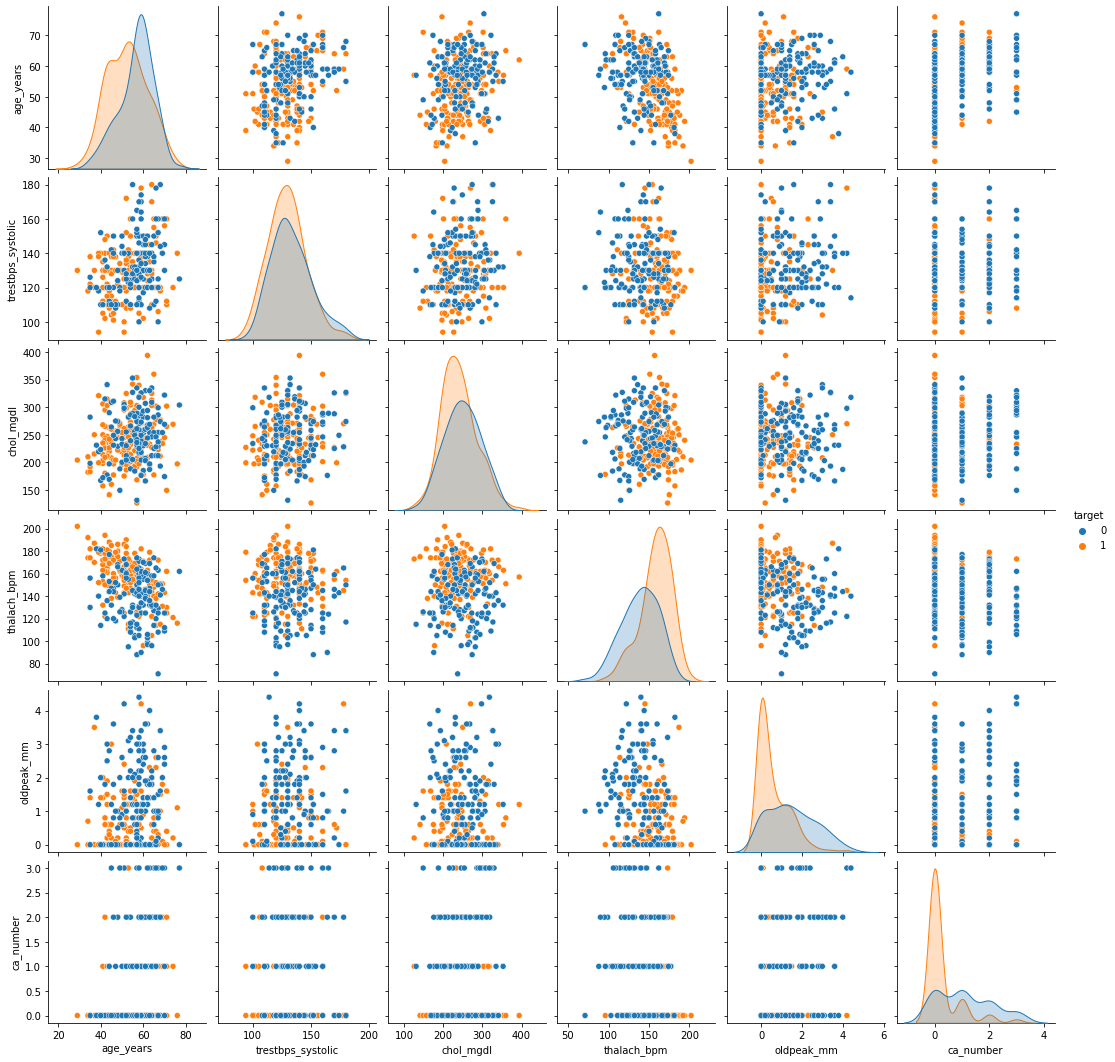

In [53]:
cols_corr = cols + ['target']
sns.pairplot(df[cols_corr], kind="scatter", hue="target");

## 5. Normalize features (Min-Max)
* i've chosen to min-max normalize becuase the featuers have different ranges and units. As showen earlier, some of the attributes doesn't normaly-distributed thus standardization is not suitable here.

In [54]:
for col in cols:
    df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
df[cols].head()

,age_years,trestbps_systolic,chol_mgdl,thalach_bpm,oldpeak_mm,ca_number
0,0.708333,0.593023,0.399254,0.603053,0.522727,0.0
1,0.166667,0.418605,0.462687,0.885496,0.795455,0.0
2,0.250000,0.418605,0.291045,0.770992,0.318182,0.0
3,0.562500,0.302326,0.410448,0.816794,0.181818,0.0
4,0.583333,0.302326,0.850746,0.702290,0.136364,0.0


In [55]:
df[cols].describe()

,age_years,trestbps_systolic,chol_mgdl,thalach_bpm,oldpeak_mm,ca_number
count,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000
mean,0.528448,0.429832,0.441186,0.598737,0.227586,0.217241
std,0.189120,0.196717,0.170806,0.175560,0.244700,0.307427
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.380208,0.302326,0.317164,0.467557,0.000000,0.000000
50%,0.541667,0.418605,0.425373,0.622137,0.181818,0.000000
75%,0.666667,0.534884,0.551306,0.725191,0.363636,0.333333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 6. Split data to Train-Test
* 80% train, 20% test

In [56]:
df.reset_index()
y = df.pop('target')
X = df
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=1989)

In [57]:
X_train.shape

(232, 32)

In [58]:
X_test.shape

(58, 32)

* check characteristics of the 2 split datasets
* differences are minor

In [59]:
X_train.describe().compare(X_test.describe())

age_years            trestbps_systolic              chol_mgdl  \
             self      other              self      other        self   
count  232.000000  58.000000        232.000000  58.000000  232.000000   
mean     0.529095   0.525862          0.425972   0.445269    0.443563   
std      0.195739   0.161436          0.197933   0.192686    0.173553   
min      0.000000   0.166667               NaN        NaN    0.000000   
25%      0.369792   0.458333               NaN        NaN    0.316231   
50%      0.541667   0.562500               NaN        NaN    0.438433   
75%      0.687500   0.640625               NaN        NaN    0.553172   
max      1.000000   0.812500               NaN        NaN    1.000000   

                 thalach_bpm             oldpeak_mm             ...  \
           other        self      other        self      other  ...   
count  58.000000  232.000000  58.000000  232.000000  58.000000  ...   
mean    0.431678    0.591011   0.629639    0.217379   0.268417  ...   
std     0.160431    0.177297   0.166326    0.233997   0.282085  ...   
min     0.115672    0.000000   0.129771         NaN        NaN  ...   
25%     0.318097    0.465649   0.547710         NaN        NaN  ...   
50%     0.402985    0.614504   0.667939    0.181818   0.170455  ...   
75%     0.540112    0.717557   0.753817    0.363636   0.454545  ...   
max     0.798507    1.000000   0.908397    1.000000   0.954545  ...   

      is_high_stage1_rbp            is_high_stage2_rbp             \
                    self      other               self      other   
count         232.000000  58.000000         232.000000  58.000000   
mean            0.232759   0.206897           0.301724   0.362069   
std             0.423503   0.408619           0.459999   0.484796   
min                  NaN        NaN                NaN        NaN   
25%                  NaN        NaN                NaN        NaN   
50%                  NaN        NaN                NaN        NaN   
75%                  NaN        NaN                NaN        NaN   
max                  NaN        NaN                NaN        NaN   

      is_hypertensive_crisis_rbp       is_normal_chol            is_high_chol  \
                            self other           self      other         self   
count                      232.0  58.0     232.000000  58.000000   232.000000   
mean                         NaN   NaN       0.168103   0.155172     0.831897   
std                          NaN   NaN       0.374767   0.365231     0.374767   
min                          NaN   NaN            NaN        NaN          NaN   
25%                          NaN   NaN            NaN        NaN          NaN   
50%                          NaN   NaN            NaN        NaN          NaN   
75%                          NaN   NaN            NaN        NaN          NaN   
max                          NaN   NaN            NaN        NaN          NaN   

                  
           other  
count  58.000000  
mean    0.844828  
std     0.365231  
min          NaN  
25%          NaN  
50%          NaN  
75%          NaN  
max          NaN  

[8 rows x 64 columns]

* inspect distribution of the datasets (thay should by closely distributed as possiable)

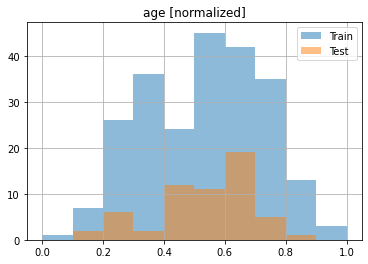

In [60]:
range=(df['age_years'].min(), df['age_years'].max())
plt.hist(X_train['age_years'], range=range, alpha=0.5, label='Train')
plt.hist(X_test['age_years'], range=range, alpha=0.5, label='Test')
plt.legend(loc='upper right')
plt.grid()
plt.title('age [normalized]')
plt.show()

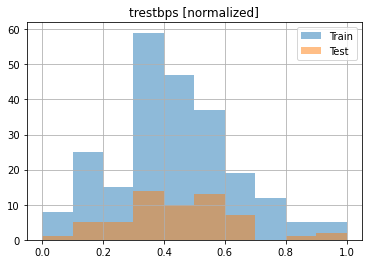

In [61]:
range=(df['trestbps_systolic'].min(), df['trestbps_systolic'].max())
plt.hist(X_train['trestbps_systolic'], range=range, alpha=0.5, label='Train')
plt.hist(X_test['trestbps_systolic'], range=range, alpha=0.5, label='Test')
plt.legend(loc='upper right')
plt.grid()
plt.title('trestbps [normalized]')
plt.show()

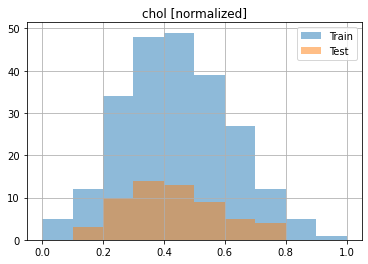

In [62]:
range=(df['chol_mgdl'].min(), df['chol_mgdl'].max())
plt.hist(X_train['chol_mgdl'], range=range, alpha=0.5, label='Train')
plt.hist(X_test['chol_mgdl'], range=range, alpha=0.5, label='Test')
plt.legend(loc='upper right')
plt.grid()
plt.title('chol [normalized]')
plt.show()

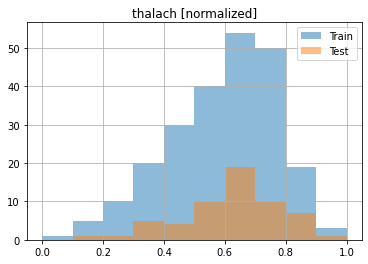

In [63]:
range=(df['thalach_bpm'].min(), df['thalach_bpm'].max())
plt.hist(X_train['thalach_bpm'], range=range, alpha=0.5, label='Train')
plt.hist(X_test['thalach_bpm'], range=range, alpha=0.5, label='Test')
plt.legend(loc='upper right')
plt.grid()
plt.title('thalach [normalized]')
plt.show()

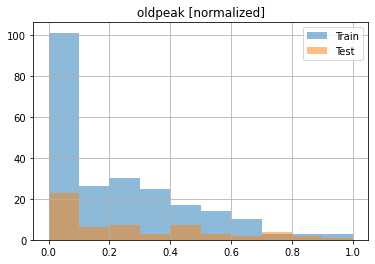

In [64]:
range=(df['oldpeak_mm'].min(), df['oldpeak_mm'].max())
plt.hist(X_train['oldpeak_mm'], range=range, alpha=0.5, label='Train')
plt.hist(X_test['oldpeak_mm'], range=range, alpha=0.5, label='Test')
plt.legend(loc='upper right')
plt.grid()
plt.title('oldpeak [normalized]')
plt.show()

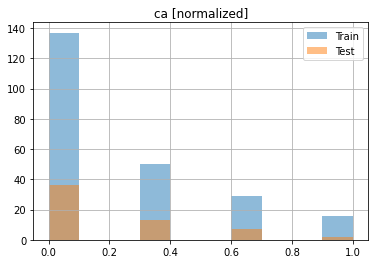

In [65]:
range=(df['ca_number'].min(), df['ca_number'].max())
plt.hist(X_train['ca_number'], range=range, alpha=0.5, label='Train')
plt.hist(X_test['ca_number'], range=range, alpha=0.5, label='Test')
plt.legend(loc='upper right')
plt.grid()
plt.title('ca [normalized]')
plt.show()

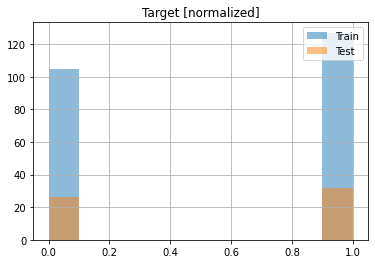

In [66]:
range=(y_train.min(), y_train.max())
plt.hist(y_train, range=range, alpha=0.5, label='Train')
plt.hist(y_test, range=range, alpha=0.5, label='Test')
plt.legend(loc='upper right')
plt.grid()
plt.title('Target [normalized]')
plt.show()

## 7. PCA (and Logistic Regression)

* Standardize the Data
* Fit on training set only
* Apply transform to both the training set and the test set

In [67]:
scaler = StandardScaler()
scaler.fit(X_train);
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Evaluate PCA and the optimal number of components using Logistic Regression

* Make an instance of the Model and fit PCA on training set only.
* Apply the mapping (transform) to both the training set and the test set.
* Make an instance of the Logistic Regression Model.
* Train the model on the data.
* Measure model performance on different values of Number of components

In [68]:
print('Logistic Regression:')
for num_components in [.80, .85, .90, .95, .98]:
    pca = PCA(num_components);
    pca.fit(X_train)
    X_train_curr = pca.transform(X_train)
    X_test_curr = pca.transform(X_test)
    
    # evaluate different values of components_percentage using Logistic Regression model
    logisticRegr = LogisticRegression(solver = 'lbfgs')
    logisticRegr.fit(X_train_curr, y_train);
    res = logisticRegr.score(X_test_curr, y_test)
    print(f'Number of components: {100 * num_components}%, Accuracy: {res:.4f}')

Logistic Regression:
Number of components: 80.0%, Accuracy: 0.8103
Number of components: 85.0%, Accuracy: 0.8103
Number of components: 90.0%, Accuracy: 0.8276
Number of components: 95.0%, Accuracy: 0.8448
Number of components: 98.0%, Accuracy: 0.8448


* Notice that the minimal num_components value performing optimaly is 95%. Meaning, it is possiable to keep only 95% of the data and still have optimal solution while speeding up the prediction process (because it uses less data).